In [1]:
import matplotlib.gridspec as gridspec
import scqubits
import numpy as np
from CoupledQuantumSystems.visualization import *
from CoupledQuantumSystems.systems import *
from tqdm import tqdm
import pickle
import scipy
from CoupledQuantumSystems.qobj_manip import *
from scipy.special import erfc
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit
import scipy
from scipy.special import erfc
from skimage.transform import radon
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
import numpy as np
from CoupledQuantumSystems.mcsolve_utils import *
from CoupledQuantumSystems.drive import DriveTerm, square_pulse_with_rise_fall
from CoupledQuantumSystems.mcsolve_utils import pack_mcsolve_chunks, pack_pkl_files_to_zip, merge_results
import matplotlib.pyplot as plt
import qutip

# linestyles = ['-',(0,(3,1,1,1)),(0,(5,2,5,2))]
# linestyles = ['-','--',':']
# import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
linestyles = ['-','-','--']
linewidth_list = [1.75,1.75,1]

colors = ['#4999c3','#d5373d','black']

In [2]:
n_evals = 20
qls = [0,1,2]
max_ol = 50
max_ql = 20

def plot_sweep_Er(ax,matrix, evals,Er_list,qls = [0,1,2],ylim=(-1,1),participating_transitions = None):
    num_evals =len(evals)

    if participating_transitions != None:
        for i in range(num_evals):
                for j in range(num_evals): 
                    if (i, j) not in participating_transitions and (j, i) not in participating_transitions:
                        matrix[i, j] = 0 

    for ql  in qls:
        color  = colors[ql]
        linestyle = linestyles[ql]
        shift_from_qubit_transition = []
        for Er in tqdm(Er_list, desc = "Er loop"):
            shifts = [get_shift_accurate(matrix[ql,ql2], evals[ql2], evals[ql], Er) for ql2 in range(num_evals)] 
            shift_from_qubit_transition.append(sum(shifts))
        ax.plot(Er_list, shift_from_qubit_transition, label=rf'$\chi_{ql}$',color = color, linestyle = linestyle)

    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    ax.set_xlim(Er_list[0],Er_list[-1])
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlabel(rf'$\omega_r$')
    ax.legend()

def alpha(t, Delta_rd, epsilon_r, kappa):
    return (-1j*epsilon_r / (1j*Delta_rd + kappa/2)) * (1 - np.exp(-(1j*Delta_rd + kappa/2)*t))

In [3]:
ef_system = '../ef_larger_drive/ef_mcsolve_system_g0.2.pkl'
gf_system = '../gf_new/gf_mcsolve_system_g3a01k002.pkl'
ef_results = '../ef_larger_drive/mcsolve_results_with_product_basis_second_batch.pkl'
gf_results = '../gf_new/mcsolve_results_with_product_basis.pkl'
ef_SNR =  '../ef_larger_drive/numbers_for_SNR_g2a015k003.pkl'
gf_SNR = '../gf_new/numbers_for_SNR.pkl'
with open(ef_system, 'rb') as f:
    system_ef = pickle.load(f)
qbt0 = system_ef.qbt
with open(gf_system, 'rb') as f:
    system_gf = pickle.load(f)
qbt1 = system_gf.qbt
with open(ef_results, 'rb') as f:
    results_ef = pickle.load(f)
with open(gf_results, 'rb') as f:
    results_gf = pickle.load(f)


with open('../ef_larger_drive/husimi_data_time_slices_5step_g2a015k003.pkl', 'rb') as f:
    ef_qfunc_results = pickle.load(f)
with open('../gf_new/husimi_data_time_slices.pkl', 'rb') as f:
    gf_qfunc_results = pickle.load(f)

In [4]:
def plot_sweep_er_ef(ax):
    matrix0 =  qbt0.matrixelement_table(operator = "n_operator",evals_count=n_evals)
    g = 0.2
    evals0 = qbt0.eigenvals(n_evals)
    Er_list0 = np.linspace(6.2,7.0,int(1e4))
    ylim  = (-2,3)
    for ql  in qls:
        shift_from_qubit_transition = []
        for Er in tqdm(Er_list0, desc = "Er loop"):
            shifts = [get_shift_accurate(matrix0[ql,ql2], evals0[ql2], evals0[ql], Er) for ql2 in range(n_evals)] 
            shift_from_qubit_transition.append(sum(shifts)*100 * g)
        ax.plot(Er_list0,np.array(shift_from_qubit_transition), label=rf'$\chi_{ql}$',color = colors[ql], linestyle = linestyles[ql],linewidth = linewidth_list[ql])
    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.set_xlim(Er_list0[0],Er_list0[-1])
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlabel(rf'$\omega_r$')
    ax.legend(loc= 'lower left')
    ax.set_xlabel(rf'$\omega_r$ (GHz)')
    ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()])
    ax.set_ylabel(r'$\chi/2\pi$ (MHz)')
    ax.scatter(6.8,1.15, marker='*', color='black', s=80,alpha=0.5,zorder=10)

    y_offset = 0.0004
    x_offset = 0.01
    ax.text(evals0[9]-evals0[2]+x_offset,y_offset,'2-9',color = colors[2])
    ax.text(evals0[10]-evals0[1]+x_offset, y_offset,'1-10',color = colors[1])
    ax.text(evals0[7]-evals0[0]+x_offset, y_offset,'0-7',color = colors[0])
    ax.text(evals0[11]-evals0[2]+x_offset, y_offset,'2-11',color = colors[2])

def plot_sweep_er_gf(ax):
    evals1 = qbt1.eigenvals(n_evals)
    matrix1 =  qbt1.matrixelement_table(operator = "n_operator",evals_count=n_evals)
    g= 0.3
    Er_list1 = np.linspace(11,16,int(1e4))
    ylim  = (-1,4)
    for ql  in qls:
        shift_from_qubit_transition = []
        for Er in tqdm(Er_list1, desc = "Er loop"):
            shifts = [get_shift_accurate(matrix1[ql,ql2], evals1[ql2], evals1[ql], Er) for ql2 in range(n_evals)] 
            shift_from_qubit_transition.append(sum(shifts)*100*g)
        ax.plot(Er_list1, np.array(shift_from_qubit_transition), label=rf'$\chi_{ql}$',color = colors[ql], linestyle = linestyles[ql],linewidth = linewidth_list[ql])

    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.set_xlim(Er_list1[0],Er_list1[-1])
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlabel(rf'$\omega_r$')
    ax.legend(loc= 'lower left')
    ax.set_xlabel(rf'$\omega_r$ (GHz)')
    ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()])
    ax.set_ylabel(r'$\chi/2\pi$ (MHz)')
    ax.scatter(13.6355,0.32, marker='*', color='black', s=80,alpha=0.5,zorder=10)
    y_offset = 2
    x_offset = 0.006
    ax.text((evals1[9]-evals1[2]+x_offset),  y_offset,'2-9',color = colors[2])
    ax.text((evals1[10]-evals1[1]+x_offset), y_offset,'1-10',color = colors[1])
    ax.text((evals1[9]-evals1[0]+x_offset), y_offset,'0-9',color = colors[0])
    ax.text((evals1[11]-evals1[2]+x_offset), y_offset,'2-11',color = colors[2])

def plot_ef_alpha(ax):
    epsilon_r = 0.015 *2*np.pi # External driving term
    kappa = 3e-3 # Decay rate of the resonator
    tot_time =400
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 346
    w_d = 6.798175922599341
    frequency_used = -1*w_d
    alpha_arr = (results_ef[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag, color='#4999c3',label = rf'$\alpha_{{\left|0\right>}}$ sim',alpha=1)
    alpha_arr = (results_ef[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag, color='#d5373d',label = rf'$\alpha_{{\left|1\right>}}$ sim',alpha=1)

    # Delta_rd = 2*np.pi*(w_d -\
    #                     (system_ef.evals[system_ef.product_to_dressed[(0,1)]]-system_ef.evals[system_ef.product_to_dressed[(0,0)]]))  # Detuning of the readout resonator
    # # alpha_t_values =( 1/np.sqrt(2)*alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # # alpha_t_values =( alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # alpha_t_values =( 1/2*alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]    
    # ax.plot(-alpha_t_values.real, alpha_t_values.imag ,color='lightblue',linestyle='--',lw=2,label=rf'$\alpha_{{\left|0\right>}}$ semi-c')

    # Delta_rd = 2*np.pi*(w_d -\
    #                     (system_ef.evals[system_ef.product_to_dressed[(1,1)]]-system_ef.evals[system_ef.product_to_dressed[(1,0)]]))  # Detuning of the readout resonator
    # # alpha_t_values = (1/np.sqrt(2)*alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # # alpha_t_values = (alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # alpha_t_values = (1/2*alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]    
    # ax.plot(-alpha_t_values.real , alpha_t_values.imag, color='pink',linestyle='--',lw=2,label=rf'$\alpha_{{\left|1\right>}}$ semi-c')

    ax.set_aspect('equal')
    ax.set_xlabel(rf'Re[$\alpha$]')
    ax.set_ylabel(rf'Im[$\alpha$]', labelpad=-6)
    # ax.legend(loc = 'upper left',prop={'size': 9})
    ax.set_xlim(-11.5,2.5)
    ax.set_ylim(-11,3)
    # ax.set_yticks([0,-4,-8])

def plot_gf_alpha(ax):
    epsilon_r = 0.01*2*np.pi  # External driving term
    kappa = 2e-3 # Decay rate of the resonator
    tot_time =500
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 449
    w_d = 13.6355
    frequency_used = -1* w_d
    alpha_arr = (results_gf[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist)  )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag,color="#4999c3",label = rf'$\alpha_{{\left|0\right>}}$ sim',alpha=1)
    alpha_arr = (results_gf[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag,color="#d5373d",label = rf'$\alpha_{{\left|1\right>}}$ sim',alpha=1)

    # Delta_rd = 2*np.pi*(w_d -\
    #                     (system_gf.evals[system_gf.product_to_dressed[(0,1)]]-system_gf.evals[system_gf.product_to_dressed[(0,0)]]))  # Detuning of the readout resonator
    # # alpha_t_values =( 1/np.sqrt(2)*alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # # alpha_t_values =( alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # alpha_t_values =( 1/2*alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # ax.plot(-alpha_t_values.real , alpha_t_values.imag, color='lightblue',linestyle=(1,(2,2,2,2)),lw=2,label=rf'$\alpha_{{\left|0\right>}}$ semi-c')

    # Delta_rd = 2*np.pi*(w_d -\
    #                     (system_gf.evals[system_gf.product_to_dressed[(1,1)]]-system_gf.evals[system_gf.product_to_dressed[(1,0)]]))
    # # alpha_t_values = (1/np.sqrt(2)*alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # # alpha_t_values = (alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # alpha_t_values = (1/2*alpha(tlist, Delta_rd, epsilon_r, kappa) )[:last_t_idx+1]
    # ax.plot(-alpha_t_values.real, alpha_t_values.imag, color='pink',linestyle='--',lw=2,label=rf'$\alpha_{{\left|1\right>}}$ semi-c')

    ax.set_aspect('equal')
    ax.set_xlabel(rf'Re[$\alpha$]')
    ax.set_ylabel(rf'Im[$\alpha$]', labelpad=-6)
    # ax.legend(loc = 'lower right',prop={'size': 9})
    ax.set_xlim(-3,12)
    ax.set_ylim(-8,7)
    # ax.set_yticks([5, 0,-5,-10])

def plot_ef_pn(ax):
    with open(ef_results, 'rb') as f:
        results = pickle.load(f)
    tot_time =400
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 346
    for ql, result in zip([0,1,2],results_ef[:3]):
        ax.plot(tlist[:last_t_idx+1],result.expect[1][:last_t_idx+1],color=colors[ql],label = rf'$\left|{ql}\right>$',alpha=0.5)
    ax.legend()
    ax.set_xlabel(rf't (ns)')
    ax.set_ylabel(rf'$\langle \alpha^\dagger \alpha \rangle$')
    ax.legend(loc = 'upper left',prop={'size': 9})

def plot_gf_pn(ax):
    tot_time =500
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 449
    for ql, result in zip([1,0,2],results_gf[:3]):
        ax.plot(tlist[:last_t_idx+1],result.expect[1][:last_t_idx+1],color=colors[ql],label = rf'$\left|{ql}\right>$',alpha=0.5)
    ax.legend()

    ax.set_xlabel(rf't (ns)')
    ax.set_ylabel(rf'$\langle \alpha^\dagger \alpha \rangle$')
    ax.legend(loc = 'upper left',prop={'size': 9})


In [5]:
def plot_sweep_Er(ax,matrix, evals,Er_list,qls = [0,1,2],ylim=(-1,1),participating_transitions = None):
    num_evals =len(evals)

    if participating_transitions != None:
        for i in range(num_evals):
                for j in range(num_evals): 
                    if (i, j) not in participating_transitions and (j, i) not in participating_transitions:
                        matrix[i, j] = 0 

    for ql  in qls:
        color  = colors[ql]
        linestyle = linestyles[ql]
        shift_from_qubit_transition = []
        for Er in tqdm(Er_list, desc = "Er loop"):
            shifts = [get_shift_accurate(matrix[ql,ql2], evals[ql2], evals[ql], Er) for ql2 in range(num_evals)] 
            shift_from_qubit_transition.append(sum(shifts))
        ax.plot(Er_list, shift_from_qubit_transition, label=rf'$\chi_{ql}$',color = color, linestyle = linestyle)

    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    ax.set_xlim(Er_list[0],Er_list[-1])
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlabel(rf'$\omega_r$')
    ax.legend()


lim = 25
xvec = np.linspace(-1*lim,lim,500)
X, Y = np.meshgrid(xvec, xvec)
QFunc_instance =  qutip.QFunc(xvec, xvec, np.sqrt(2),memory=4096)

def get_q_value(ql,t_idx, results, frequency_used, max_ol, tlist):
    rho_product = results[ql].states_in_product_basis[t_idx]
    rho = qutip.Qobj(np.array(rho_product.ptrace(1)))
    # U_inv = ( -1j  *  frequency_used * 2*np.pi * qutip.create(max_ol) * qutip.destroy(max_ol) * tlist[t_idx] ).expm().dag()  # Inverse rotation operator

    U_inv = ( 1j  *  frequency_used * 2*np.pi * qutip.create(max_ol) * qutip.destroy(max_ol) * tlist[t_idx] ).expm().dag()  # Inverse rotation operator
    rho = U_inv * rho * U_inv.dag()

    rho = rho/rho.tr()
    rho = (rho + rho.dag()) / 2

    q_values = QFunc_instance(rho)
    return q_values

def plot_qfunc_cdf_contours(ax, q_values,levels = [0.001,0.5,0.99, 0.999],color='black'):
    sorted_q = np.sort(q_values.ravel())
    cumulative_sum = np.cumsum(sorted_q)
    total_sum = cumulative_sum[-1]
    for prob in levels:
        alpha = np.sqrt(1-prob)
        
        level_value = sorted_q[np.argmax(cumulative_sum >= total_sum * (1 - prob))]
        # fmt = {level_value:f'{1 - prob:.2f}'}   
        contour = ax.contour(X, Y, q_values, levels=[level_value], colors=color,alpha=alpha)
        # ax.clabel(contour, inline=False, fontsize=8, fmt=fmt,colors='black') 

def gaussian(xvec, A, mu, sigma):
    return A * np.exp(-0.5 * ((xvec - mu) / sigma)**2)

def fit_gaussian(y,xvec,print_fit = False):
    popt, pcov = curve_fit(gaussian, xvec, y, p0=[np.max(y), xvec[np.argmax(y)], 1]) 
    for i in range(len(pcov)):
        if pcov[i][i] >= 5e-3:
            raise Exception(f'covariance too large: {pcov[i][i]}')     
    A, mu, sigma =  popt
    return A, mu, sigma

def get_fit_accuracy(y,xvec, A, mu, sigma):
    y_fit = gaussian(xvec, A, mu, sigma)
    RSS = np.sum((y_fit - y_fit)**2) #Residual Sum of Squares 
    TSS = np.sum((y - np.mean(y))**2)
    R_squared = 1 - (RSS / TSS) # how much of the variance is explained by the model
    RMSE = np.sqrt(np.mean((y - y_fit)**2)) #  Root Mean Square Error
    # print("RSS:", RSS)
    # print("R-squared (R²) value:", R_squared)
    # print("RMSE:", RMSE)
    return RSS, R_squared, RMSE

from scipy.stats import norm
def calculate_overlap(q_values_leak,q_values_compu,theta):
    y_leak = radon(q_values_leak,theta=theta).flatten()
    y_compu = radon(q_values_compu,theta=theta).flatten()

    A_leak, mu_leak, sigma_leak = fit_gaussian(y_leak,xvec=xvec)
    A_compu, mu_compu, sigma_compu = fit_gaussian(y_compu,xvec=xvec)

    # Compute the probability density functions (PDFs) of the two Gaussian distributions
    min_mean = min(mu_leak - 4 * sigma_leak, mu_compu - 4 * sigma_compu)
    max_mean = max(mu_leak + 4 * sigma_leak, mu_compu + 4 * sigma_compu)
    x_values = np.linspace(min_mean, max_mean, 1000)
    pdf1 = norm.pdf(x_values, mu_leak, sigma_leak) * A_leak
    pdf2 = norm.pdf(x_values, mu_compu, sigma_compu) * A_compu
    overlap_area = np.trapz(np.minimum(pdf1, pdf2), x_values)
    return overlap_area

from scipy.optimize import minimize
def optimize_theta(q_values_leak,q_values_compu,guess=10.0):
    def objective(params):
        return calculate_overlap(q_values_leak,q_values_compu,params)
    initial_guess = np.array([guess])
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x[0]

# def plot_ef_qfunc(ax):
#     t_indices = [0, 70, 140, 210, 280, 346]
#     for t_idx,result in zip(t_indices[1::2],ef_qfunc_results[1::2]):
#         q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result
#         # theta = -theta[0]/180*np.pi    
#         # if t_idx == 0:
#         #     theta = 0

#         # rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
#         #                             [np.sin(theta), np.cos(theta)]])

#         # new_x_leak, new_y_leak =  np.dot(rotation_matrix,np.array([xvec, y_leak]))
#         # new_x_compu0, new_y_compu0 =  np.dot(rotation_matrix,np.array([xvec, y_compu0]))
#         # new_x_compu1, new_y_compu1 =  np.dot(rotation_matrix,np.array([xvec, y_compu1]))
#         # ax.plot(new_x_leak, new_y_leak,color=colors[0],alpha=1)
#         # ax.plot(new_x_compu0, new_y_compu0,color=colors[1],alpha=1)
#         # ax.plot(new_x_compu1, new_y_compu1,color=colors[2],alpha=1,linestyle=(0,(3,3)))

#         plot_qfunc_cdf_contours(ax, q_values_leak,levels = [0.3,0.9,0.99],color = '#4999c3')
#         plot_qfunc_cdf_contours(ax, q_values_compu0,levels = [0.3,0.9,0.99],color = "#d5373d")
#         # plot_qfunc_cdf_contours(ax, q_values_compu1,levels = [0.3,0.9,0.99])

# def plot_gf_qfunc(ax):
#     t_indices = [0, 90, 180, 270, 360, 449]
#     for t_idx,result in zip(t_indices[1::2],gf_qfunc_results[1::2]):
#         q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result

#         # theta = -theta[0]/180*np.pi    
#         # if t_idx == 0:
#         #     theta = 0
#         # rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
#         #                             [np.sin(theta), np.cos(theta)]])

#         # new_x_leak, new_y_leak =  np.dot(rotation_matrix,np.array([xvec, y_leak]))
#         # new_x_compu0, new_y_compu0 =  np.dot(rotation_matrix,np.array([xvec, y_compu0]))
#         # new_x_compu1, new_y_compu1 =  np.dot(rotation_matrix,np.array([xvec, y_compu1]))
#         # ax.plot(new_x_leak, new_y_leak,color=colors[0],alpha=1)
#         # ax.plot(new_x_compu0, new_y_compu0,color=colors[1],alpha=1)
#         # ax.plot(new_x_compu1, new_y_compu1,color=colors[2],alpha=1,linestyle=(0,(3,3)))

#         plot_qfunc_cdf_contours(ax, q_values_leak,levels = [0.3,0.9,0.99],color = "#4999c3")
#         plot_qfunc_cdf_contours(ax, q_values_compu0,levels = [0.3,0.9,0.99],color = '#d5373d')
#         # plot_qfunc_cdf_contours(ax, q_values_compu1,levels = [0.3,0.9,0.99])

level_to_draw = [0.1,0.5,0.9,0.99]
def plot_ef_qfunc(ax):
    t_indices = [0, 70, 140, 210, 280, 346]
    for t_idx,result in zip(t_indices,ef_qfunc_results):
        q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result
        plot_qfunc_cdf_contours(ax, q_values_leak,levels = level_to_draw,color = '#4999c3')
        plot_qfunc_cdf_contours(ax, q_values_compu0,levels = level_to_draw,color = "#d5373d")

def plot_gf_qfunc(ax):
    t_indices = [0, 90, 180, 270, 360, 449]
    for t_idx,result in zip(t_indices,gf_qfunc_results):
        q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result
        plot_qfunc_cdf_contours(ax, q_values_leak,levels = level_to_draw,color = "#4999c3")
        plot_qfunc_cdf_contours(ax, q_values_compu0,levels = level_to_draw,color = '#d5373d')

In [6]:
def plot_ef_SNR(ax):
    efficiency = 1
    kappa = 3e-3 # Decay rate of the resonator
    tot_time =400
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 346
    w_d = 6.798175922599341
    frequency_used = -1*w_d
    alpha_arr_0 = np.sqrt(kappa)*(results_ef[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    alpha_arr_1 = np.sqrt(kappa)*(results_ef[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    diff_arr = np.abs(alpha_arr_0-alpha_arr_1)
    numerator = np.sqrt(kappa * efficiency) * scipy.integrate.cumulative_trapezoid(diff_arr, tlist[:last_t_idx+1],initial=0)
    denominator =np.sqrt(kappa *  tlist[:last_t_idx+1] / 2 * 2)
    denominator[0]+= 1e-10 # avoid dividing by zero
    SNR = numerator / denominator
    ax.plot(tlist[:last_t_idx+1],SNR,color='black',linestyle='--',label='SNR')


    with open(ef_SNR, 'rb') as file:
        (A_leak_list, mu_leak_list, sigma_leak_list, A_compu_list, mu_compu_list, sigma_compu_list, leak_fit_accuracies, compu_fit_accuracies) = pickle.load(file)
    contrast = np.abs(np.array(mu_leak_list)-np.array(mu_compu_list))
    contrast = np.array(contrast)[:last_t_idx+1]
    weight = contrast
    # weight = np.ones_like(contrast)
    weight_integral = np.trapz(weight,tlist[:last_t_idx+1])
    constant_weight_integral  = np.trapz(np.ones_like(contrast), tlist[:last_t_idx+1])
    weight = weight/(weight_integral / constant_weight_integral)
    integrated_contrast =  np.sqrt(kappa*efficiency)*scipy.integrate.cumulative_trapezoid(np.sqrt(kappa)*contrast*weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_leakage = kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_leak_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_compu =kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_compu_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_sd = np.sqrt(integrated_variance_leakage + integrated_variance_compu)
    snr = integrated_contrast / integrated_sd
    ax.plot(tlist[:last_t_idx+1],snr,color='black',label='SNR-weighted')

    ax.legend(loc = 'upper left',bbox_to_anchor = (-0.1,-0.4))
    ax.set_xlabel(rf't (ns)')
    ax.set_yticks([0,2,4,6,8])

def plot_gf_SNR(ax):
    efficiency = 1
    kappa = 2e-3 # Decay rate of the resonator
    tot_time =500
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 449
    w_d = 13.6355
    frequency_used = -1* w_d
    alpha_arr_0 = np.sqrt(kappa)*(results_gf[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    alpha_arr_1 = np.sqrt(kappa)*(results_gf[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    diff_arr = np.abs(alpha_arr_0-alpha_arr_1)
    numerator = np.sqrt(kappa * efficiency) * scipy.integrate.cumulative_trapezoid(diff_arr, tlist[:last_t_idx+1],initial=0)
    denominator =np.sqrt(kappa *  tlist[:last_t_idx+1] / 2 * 2)
    denominator[0]+= 1e-10 # avoid dividing by zero
    SNR = numerator / denominator
    ax.plot(tlist[:last_t_idx+1],SNR,color='black',linestyle='--',label='SNR')


    with open(gf_SNR, 'rb') as file:
        (A_leak_list, mu_leak_list, sigma_leak_list, A_compu_list, mu_compu_list, sigma_compu_list, leak_fit_accuracies, compu_fit_accuracies) = pickle.load(file)
    contrast = np.abs(np.array(mu_leak_list)-np.array(mu_compu_list))
    contrast = np.array(contrast)[:last_t_idx+1]
    weight = contrast
    # weight = np.ones_like(contrast)
    weight_integral = np.trapz(weight,tlist[:last_t_idx+1])
    constant_weight_integral  = np.trapz(np.ones_like(contrast), tlist[:last_t_idx+1])
    weight = weight/(weight_integral / constant_weight_integral)
    integrated_contrast =  np.sqrt(kappa*efficiency)*scipy.integrate.cumulative_trapezoid(np.sqrt(kappa)*contrast*weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_leakage = kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_leak_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_compu =kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_compu_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_sd = np.sqrt(integrated_variance_leakage + integrated_variance_compu)
    snr = integrated_contrast / integrated_sd
    ax.plot(tlist[:last_t_idx+1],snr,color='black',label='SNR-weighted')

    ax.legend(loc = 'upper left',bbox_to_anchor = (-1.5,1.0))
    ax.set_xlabel(rf't (ns)')

# Combine the plots

Er loop: 100%|██████████| 10000/10000 [00:00<00:00, 93998.64it/s]
 /tmp/ipykernel_101555/1036445083.py: 49RuntimeWarning: invalid value encountered in divide
 /tmp/ipykernel_101555/1899227764.py: 32RuntimeWarning: invalid value encountered in divide
 /tmp/ipykernel_101555/1899227764.py: 70

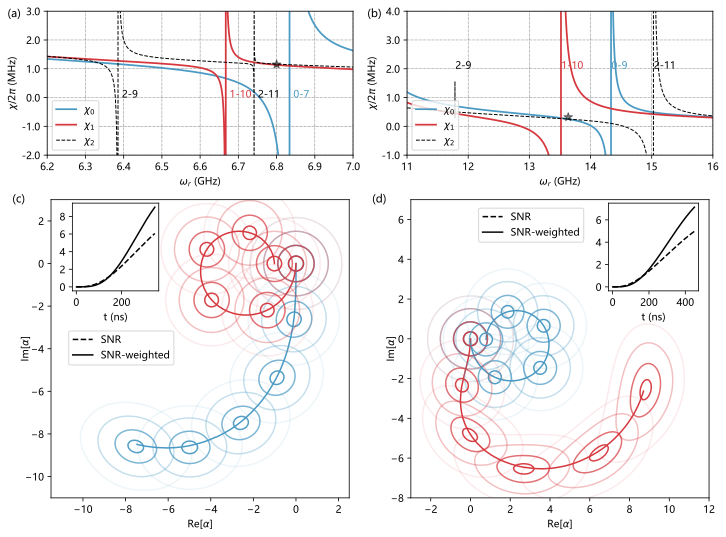

In [12]:
fig = plt.figure(figsize=(10, 7.5)) 
row_h1 = 0.65
second_row_height = 1/3
half_w = 1/2
l = 0.09
r = 0.94
# Chi
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=half_w*l, right=half_w*r,
                                        bottom=row_h1+second_row_height*0.15,top = row_h1+second_row_height*0.95)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=half_w+half_w*l, right=half_w+half_w*r,
                                        bottom=row_h1+second_row_height*0.15,top = row_h1+second_row_height*0.95)
ax0 = fig.add_subplot(gs0[0])
ax1 = fig.add_subplot(gs1[0])

# Alpha
gs0_ef = fig.add_gridspec(nrows=1, ncols=1,left=half_w*l, right=half_w*r,
                                        bottom=row_h1*0.1,top = row_h1*0.95)

ax0_ef = fig.add_subplot(gs0_ef[0])
gs0_gf = fig.add_gridspec(nrows=1, ncols=1,left=half_w+half_w*l, right=half_w+half_w*r,
                                        bottom=row_h1*0.1,top = row_h1*0.95)
ax0_gf = fig.add_subplot(gs0_gf[0])

# SNR
gs1_ef = fig.add_gridspec(nrows=1, ncols=1,left=half_w*0.16, right=half_w*0.4,
                                        bottom=row_h1*0.69,top = row_h1*0.94)
ax1_ef = fig.add_subplot(gs1_ef[0])
gs1_gf = fig.add_gridspec(nrows=1, ncols=1,left=half_w+half_w*0.65, right=half_w+half_w*0.9,
                                        bottom=row_h1*0.69,top = row_h1*0.94)
ax1_gf = fig.add_subplot(gs1_gf[0])

# gs2_ef = fig.add_gridspec(nrows=1, ncols=1,left=half_w*0.15, right=half_w*0.35,
#                                         bottom=row_h1*0.45,top = row_h1*0.65)
# ax2_ef = fig.add_subplot(gs2_ef[0])

# gs2_gf = fig.add_gridspec(nrows=1, ncols=1,left=half_w+half_w*0.15, right=half_w+half_w*0.35,
#                                         bottom=row_h1*0.2,top = row_h1*0.4)
# ax2_gf = fig.add_subplot(gs2_gf[0])

# gs3_ef = fig.add_gridspec(nrows=1, ncols=1,left=half_w+half_w*l, right=half_w+half_w*r,
#                                         bottom=row_h1*0.1,top = row_h1*0.44)
# ax3_ef = fig.add_subplot(gs3_ef[0])

# gs3_gf = fig.add_gridspec(nrows=1, ncols=1,left=half_w+half_w*l, right=half_w+half_w*0.98,
#                                         bottom=row_h1+row_h1*0.1,top = row_h1+row_h1*0.44)
# ax3_gf = fig.add_subplot(gs3_gf[0])

plt.text(-0.13, 1.02, '(a)', transform=plt.subplot(gs0[0]).transAxes, fontsize=11, va='top', color='black')
plt.text(-0.13, 1.02, '(b)', transform=plt.subplot(gs1[0]).transAxes, fontsize=11, va='top', color='black')
plt.text(-0.13, 1.02, '(c)', transform=plt.subplot(gs0_ef[0]).transAxes, fontsize=11, va='top', color='black')
plt.text(-0.13, 1.02, '(d)', transform=plt.subplot(gs0_gf[0]).transAxes, fontsize=11, va='top', color='black')

# plt.text(-0.26, 1.02, '(c)', transform=plt.subplot(gs1_ef[0]).transAxes, fontsize=11, va='top', color='black')
# plt.text(-0.4, 1.02, '(d)', transform=plt.subplot(gs2_ef[0]).transAxes, fontsize=11, va='top', color='black')
# plt.text(-0.3, 1.02, '(e)', transform=plt.subplot(gs3_ef[0]).transAxes, fontsize=11, va='top', color='black')

# plt.text(-0.26, 1.02, '(h)', transform=plt.subplot(gs1_gf[0]).transAxes, fontsize=11, va='top', color='black')
# plt.text(-0.4, 1.02, '(i)', transform=plt.subplot(gs2_gf[0]).transAxes, fontsize=11, va='top', color='black')
# plt.text(-0.3, 1.02, '(j)', transform=plt.subplot(gs3_gf[0]).transAxes, fontsize=11, va='top', color='black')


plot_sweep_er_ef(ax0)
plot_sweep_er_gf(ax1)
plot_ef_alpha(ax0_ef)
plot_ef_qfunc(ax0_ef)
plot_gf_alpha(ax0_gf)
plot_gf_qfunc(ax0_gf)

plot_ef_SNR(ax1_ef)
plot_gf_SNR(ax1_gf)

# plot_gf_pn(ax1_gf)
# plot_ef_pn(ax1_ef)
# plot_ef_non_linearity(ax2_ef)
# plot_gf_non_linearity(ax2_gf)
plt.savefig("photon_number_SNR_with_qfunc_large_drive.pdf", transparent=True, bbox_inches='tight')

In [61]:

def plot_ef_non_linearity(ax):
    def dressed_ener(ql,ol):
        return system_ef.evals[system_ef.product_to_dressed[(ql,ol)]]
    n_osc_lvls =70
    dressed_osc_frequencies = [[] for _ in range(3)]
    for j in [0,1,2]:
        for i in range(0,system_ef.osc.truncated_dim-1):
            dressed_osc_frequencies[j].append(dressed_ener(j,i+1)-dressed_ener(j,i))   
    for j in [1,2]:
        ax.plot(list(range(system_ef.osc.truncated_dim-1))[:n_osc_lvls], dressed_osc_frequencies[j][:n_osc_lvls],label=rf'$\omega_{{{j},n+1}} - \omega_{{{j},n}}$',color = colors[j], linestyle = linestyles[j],linewidth = linewidth_list[j])
    ax.set_xticks(list(range(n_osc_lvls))[::10])
    ax.set_xlim(0,65)
    ax.set_ylim( 6.801,6.8013)
    ax.legend(loc = 'upper left',prop={'size': 9})
    ax.set_ylabel(rf'$\omega_r$ $(GHz/2\pi)$')
    ax.set_xlabel(r'$n_p$')
    ax.ticklabel_format(useOffset=False, style='plain')

def plot_gf_non_linearity(ax):
    def dressed_ener(ql,ol):
        return system_gf.evals[system_gf.product_to_dressed[(ql,ol)]]
    n_osc_lvls =70
    dressed_osc_frequencies = [[] for _ in range(3)]
    for j in [0,1,2]:
        for i in range(0,system_gf.osc.truncated_dim-1):
            dressed_osc_frequencies[j].append(dressed_ener(j,i+1)-dressed_ener(j,i))   
    for j in [0,2]:
        ax.plot(list(range(system_gf.osc.truncated_dim-1))[:n_osc_lvls], dressed_osc_frequencies[j][:n_osc_lvls],label=rf'$\omega_{{{j},n+1}} - \omega_{{{j},n}}$',color = colors[j], linestyle = linestyles[j],linewidth = linewidth_list[j])
    ax.set_xticks(list(range(n_osc_lvls))[::10])
    ax.set_ylim(13.6332,13.63325)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlim(0,65)
    ax.legend(loc = 'upper right',prop={'size': 9})
    ax.set_ylabel(rf'$\omega_r$ $(GHz/2\pi)$')
    ax.set_xlabel(r'$n_p$')


def plot_ef_qbt_non_linearity(ax,Lamda = None):
    def dressed_ener(ql,ol):
        return system_ef.evals[system_ef.product_to_dressed[(ql,ol)]]
    n_osc_lvls =70
    dressed_qbt_frequencies = []
    for i in range(0,system_ef.osc.truncated_dim-1):
        dressed_qbt_frequencies.append(dressed_ener(2,i)-dressed_ener(1,i))   
    ax.plot(list(range(system_ef.osc.truncated_dim-1))[:n_osc_lvls], dressed_qbt_frequencies[:n_osc_lvls],label=rf'$\omega_{{ef,n}}$',color = '#d5373d', linestyle = '-',linewidth = 1.75)
    if Lamda is not None:
        linear_frequencies = np.array([dressed_qbt_frequencies[0] for _ in range(system_ef.osc.truncated_dim-1)])
        linear_frequencies += Lamda*np.array(list(range(system_ef.osc.truncated_dim-1)))
        ax.plot(list(range(system_ef.osc.truncated_dim-1))[:n_osc_lvls], linear_frequencies[:n_osc_lvls],label=rf'$\omega_{{ef,0}}+n\Lambda$',color = '#d5373d', linestyle = '--',linewidth = 1.75)
    ax.set_xticks(list(range(n_osc_lvls))[::10])
    ax.set_xlim(0,65)
    ax.set_ylim( 0.003,0.006)
    ax.legend(loc = 'upper left',prop={'size': 9})
    ax.set_ylabel(rf'$\omega_r$ $(GHz/2\pi)$')
    ax.set_xlabel(r'$n_p$')
    ax.ticklabel_format(useOffset=False, style='plain')

def plot_gf_qbt_non_linearity(ax,Lamda = None):
    def dressed_ener(ql,ol):
        return system_gf.evals[system_gf.product_to_dressed[(ql,ol)]]
    n_osc_lvls =70
    dressed_qbt_frequencies = []
    for i in range(0,system_gf.osc.truncated_dim-1):
        dressed_qbt_frequencies.append(dressed_ener(2,i)-dressed_ener(0,i))   
    ax.plot(list(range(system_gf.osc.truncated_dim-1))[:n_osc_lvls], dressed_qbt_frequencies[:n_osc_lvls],label=rf'$\omega_{{gf,n}}$',color = '#4999c3', linestyle = '-',linewidth = 1.75)
    if Lamda is not None:
        linear_frequencies = np.array([dressed_qbt_frequencies[0] for _ in range(system_gf.osc.truncated_dim-1)])
        linear_frequencies += Lamda*np.array(list(range(system_gf.osc.truncated_dim-1)))
        ax.plot(list(range(system_gf.osc.truncated_dim-1))[:n_osc_lvls], linear_frequencies[:n_osc_lvls],label=rf'$\omega_{{gf,0}}+n\Lambda$',color = '#4999c3', linestyle = '--',linewidth = 1.75)
    ax.set_xticks(list(range(n_osc_lvls))[::10])
    # ax.set_ylim(13.6332,13.63325)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlim(0,65)
    ax.legend(loc = 'upper right',prop={'size': 9})
    ax.set_ylabel(rf'$\omega_r$ $(GHz/2\pi)$')
    ax.set_xlabel(r'$n_p$')

Text(-0.5, 1.02, '(d)')

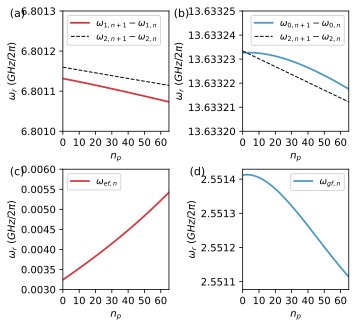

In [8]:

fig = plt.figure(figsize=(5, 4.4)) 
l = 0.35
r = 0.94

half_w = 0.5
t= 0.98
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=half_w*l, right=half_w*r,
                                        bottom=0.6,top =t)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=half_w+half_w*l, right=half_w+half_w*r,
                                        bottom=0.6,top = t)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=half_w*l, right=half_w*r,
                                        bottom=0.1,top =0.48)
gs3 = fig.add_gridspec(nrows=1, ncols=1,left=half_w+half_w*l, right=half_w+half_w*r,
                                        bottom=0.1,top = 0.48)
ax0 = fig.add_subplot(gs0[0])
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs2[0])
ax3 = fig.add_subplot(gs3[0])
plot_ef_non_linearity(ax0)
plot_gf_non_linearity(ax1)
plot_ef_qbt_non_linearity(ax2)
plot_gf_qbt_non_linearity(ax3)


plt.text(-0.5, 1.02, '(a)', transform=plt.subplot(gs0[0]).transAxes, fontsize=11, va='top', color='black')
plt.text(-0.65, 1.02, '(b)', transform=plt.subplot(gs1[0]).transAxes, fontsize=11, va='top', color='black')
plt.text(-0.5, 1.02, '(c)', transform=plt.subplot(gs2[0]).transAxes, fontsize=11, va='top', color='black')
plt.text(-0.5, 1.02, '(d)', transform=plt.subplot(gs3[0]).transAxes, fontsize=11, va='top', color='black')

# plt.savefig("non_linearity.pdf", transparent=True)

Text(0, 0.5, '$\\langle \\hat{a}^\\dagger\\hat{a} \\rangle$')

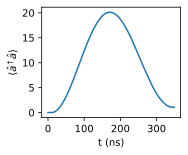

In [9]:
last_t_idx = 349
fig, ax = plt.subplots(1,1,figsize=(2.5,2))
ax.plot(results_ef[3].expect[1][:last_t_idx+1].real)
ax.set_xlabel('t (ns)')
ax.set_ylabel(rf'$\langle \hat{{a}}^\dagger\hat{{a}} \rangle$')

# plt.savefig("photon_number_ef.pdf", transparent=True)

Text(0, 0.5, '$\\langle \\hat{a}^\\dagger\\hat{a} \\rangle$')

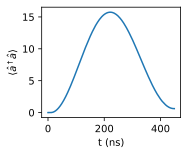

In [10]:
last_t_idx = 449
fig, ax = plt.subplots(1,1,figsize=(2.5,2))
ax.plot(results_gf[3].expect[1][:last_t_idx+1].real)
ax.set_xlabel('t (ns)')
ax.set_ylabel(rf'$\langle \hat{{a}}^\dagger\hat{{a}} \rangle$')

# plt.savefig("photon_number_gf.pdf", transparent=True)

 /home/kai/miniconda3/envs/dynamiqs/lib/python3.10/site-packages/matplotlib/cbook.py: 1709ComplexWarning: Casting complex values to real discards the imaginary part
 /home/kai/miniconda3/envs/dynamiqs/lib/python3.10/site-packages/matplotlib/cbook.py: 1345

(1e-08, 0.0001)

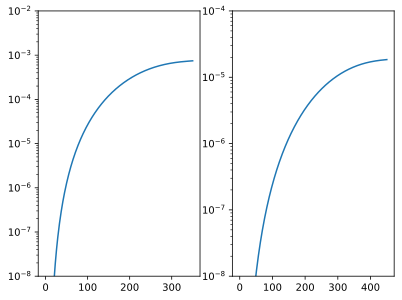

In [31]:
def nbar_interpolated(t, tlist, nbar_vals):
    """
    Return the mean photon number at time t by interpolating
    the numerically obtained nbar values in nbar_vals 
    vs. the time grid tlist.
    """
    return np.interp(t, tlist, nbar_vals)

from scipy.interpolate import interp1d

def compute_dephasing_time_evolution(tlist, nbar_vals, Lambda, tau_c, uniform_num_points=2000):
    """
    Compute the time-dependent dephasing (coherence, mean_phi, var_phi) for each t in `tlist`,
    using cumulative integration on a single uniform grid [0..tmax].

    Parameters
    ----------
    tlist : 1D array
        The original time points of interest (e.g. from your simulation).
    nbar_vals : 1D array (same length as tlist)
        Mean photon number at each point in tlist.
    Lambda : float
        The linear dependence coefficient (ωₘ(q)(n) = ω₀ + n⋅Λ).
    tau_c : float
        Correlation timescale (1/κ from your exponent).
    uniform_num_points : int
        Size of the uniform grid used for the 2D integral. Larger ⇒ more accurate but slower.

    Returns
    -------
    coherence_at_t : complex ndarray (same length as tlist)
        The coherence factor vs. time, exp(i⋅mean_phi(t) - 0.5⋅var_phi(t)).
    mean_phi_at_t : float ndarray (same length as tlist)
        The accumulated mean phase shift up to each time in tlist.
    var_phi_at_t : float ndarray (same length as tlist)
        The accumulated phase variance up to each time in tlist.
    """

    # 1) Interpolate nbar(t) onto a function f_nbar for continuous domain
    assert len(tlist) == len(nbar_vals), "tlist and nbar_vals must match in length."
    f_nbar = interp1d(tlist, nbar_vals, kind='linear',
                      bounds_error=False, fill_value='extrapolate')

    # 2) Build a uniform grid from t=0.. t_max
    t_min, t_max = np.min(tlist), np.max(tlist)
    Ts = np.linspace(t_min, t_max, uniform_num_points)   # e.g., [0, ..., t_max]
    dt = Ts[1] - Ts[0]

    # 3) Evaluate nbar on the uniform grid
    nbar_grid = f_nbar(Ts)  # shape: (uniform_num_points,)

    # ----------------------------------------------------------------------
    # (A) Compute mean_phi(t) on the uniform grid using a 1D cumulative integral
    # mean_phi(t) = Λ · ∫₀ᵗ nbar(τ) dτ
    # We can do a discrete trapezoid cumsum via "cumulative_trapezoid" from scipy.
    #
    # cumulative_trapezoid(y, x, initial=0) => array of same length as y
    # whose i-th element is ∫ from x[0] to x[i].
    # ----------------------------------------------------------------------
    mean_phi_uniform = Lambda * scipy.integrate.cumulative_trapezoid(nbar_grid, Ts, initial=0)

    # ----------------------------------------------------------------------
    # (B) Compute var_phi(t) on the uniform grid via 2D cumsum:
    #     var_phi(t) = Λ² ∫₀ᵗ ∫₀ᵗ K(t₁, t₂) dt₁ dt₂
    #     where K(t₁,t₂) = sqrt( nbar(t₁)*nbar(t₂) ) * exp(-|t₁ - t₂| / tau_c).
    #
    # We'll build a 2D array Kvals on [0..t_max], then do cumsum in 2D. 
    # The integral from 0..i in each dimension is cumsum2d[i, i]* (dt²) in a rectangle rule.
    # ----------------------------------------------------------------------
    T1, T2 = np.meshgrid(Ts, Ts, indexing='ij')  # shape: (N, N)
    # We can broadcast nbar_grid for T1 and T2:
    # nbar_grid is shape (N,). We'll reshape to (N,1) and (1,N).
    nbar_t1 = nbar_grid.reshape(-1, 1)  # shape (N,1)
    nbar_t2 = nbar_grid.reshape(1, -1)  # shape (1,N)

    Kvals = np.sqrt(nbar_t1 * nbar_t2) * np.exp(-np.abs(T1 - T2)/tau_c) 
    # shape: (N, N)

    # 2D cumulative sum
    cumsum2d = np.cumsum(np.cumsum(Kvals, axis=0), axis=1)  
    # cumsum2d[i, j] is sum of all Kvals up to i, j indices (rectangle in index‐space).
    # The approximate integral is cumsum2d[i,j] * dt² in simple rectangle rule.

    # On the diagonal i=j, that corresponds to t=Ts[i]. 
    # So var_phi_uniform[i] = Λ² * cumsum2d[i,i] * dt²
    var_phi_uniform = Lambda**2 * (np.diag(cumsum2d) * dt**2)

    # ----------------------------------------------------------------------
    # (C) Coherence(t) on the uniform grid
    # coherence_uniform[i] = exp(i * mean_phi_uniform[i] - 0.5 * var_phi_uniform[i])
    # ----------------------------------------------------------------------
    coherence_uniform = np.exp(1j * mean_phi_uniform - 0.5 * var_phi_uniform)

    # ----------------------------------------------------------------------
    # 4) Interpolate these uniform-grid results back onto tlist
    # We do separate real/imag for coherence because interpolation is real‐valued:
    # ----------------------------------------------------------------------
    real_coh_uniform = np.real(coherence_uniform)
    imag_coh_uniform = np.imag(coherence_uniform)

    f_mean_phi = interp1d(Ts, mean_phi_uniform, kind='linear', bounds_error=False, fill_value='extrapolate')
    f_var_phi  = interp1d(Ts, var_phi_uniform,  kind='linear', bounds_error=False, fill_value='extrapolate')
    f_coh_real = interp1d(Ts, real_coh_uniform, kind='linear', bounds_error=False, fill_value='extrapolate')
    f_coh_imag = interp1d(Ts, imag_coh_uniform, kind='linear', bounds_error=False, fill_value='extrapolate')

    mean_phi_at_t = f_mean_phi(tlist)
    var_phi_at_t  = f_var_phi(tlist)
    real_coh_at_t = f_coh_real(tlist)
    imag_coh_at_t = f_coh_imag(tlist)

    # Rebuild the complex coherence
    coherence_at_t = real_coh_at_t + 1j*imag_coh_at_t

    return coherence_at_t, mean_phi_at_t, var_phi_at_t


# Dephasing for e-f
tot_time = 400
tlist_ef_ori = np.linspace(0, tot_time, tot_time)
last_t_idx_ef = 349
ef_tlist =tlist_ef_ori[:last_t_idx_ef+1]
_, _, ef_dephasing = compute_dephasing_time_evolution(ef_tlist, results_ef[3].expect[1][:last_t_idx_ef+1], 3.1 *1e-5, 1/3e-3, uniform_num_points=2000)

tot_time =500
tlist_gf_ori = np.linspace(0, tot_time, tot_time)
last_t_idx_gf = 449
gf_tlist = tlist_gf_ori[:last_t_idx_gf+1]
_, _, gf_dephasing = compute_dephasing_time_evolution(gf_tlist, results_gf[3].expect[1][:last_t_idx_gf+1], 4.2 *1e-6, 1/2e-3, uniform_num_points=2000)

fig, axes = plt.subplots(1,2)
axes[0].plot(ef_tlist, ef_dephasing)
axes[1].plot(gf_tlist, gf_dephasing)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_ylim(1e-8,1e-2)
axes[1].set_ylim(1e-8,1e-4)

# Measurement dephasing (incoherent)

In [57]:
# This is dephasing due to decay
def readout_dephasing(epsilon, kappa, chi_a,chi_b,Delta):
    return  (2 * epsilon**2 * kappa * (chi_a-chi_b)**2 )  / (    4*(Delta+chi_a)**2+kappa**2      +  4*(Delta+chi_b)**2+kappa**2             )


chi_0 = (system_ef.evals[system_ef.product_to_dressed[(0,1)]] - system_ef.evals[system_ef.product_to_dressed[(0,0)]]) - system_ef.osc.E_osc
chi_1 = (system_ef.evals[system_ef.product_to_dressed[(1,1)]] - system_ef.evals[system_ef.product_to_dressed[(1,0)]]) - system_ef.osc.E_osc
chi_2 = (system_ef.evals[system_ef.product_to_dressed[(2,1)]] - system_ef.evals[system_ef.product_to_dressed[(2,0)]]) - system_ef.osc.E_osc
Gamma = readout_dephasing(epsilon = 0.0942 , kappa = 0.003, chi_a = chi_1,chi_b=chi_2,Delta=-chi_0)
print(f"ef-qubit decay dephasing {1-np.exp(-1* Gamma * 347)}")

chi_0 = (system_gf.evals[system_gf.product_to_dressed[(0,1)]] - system_gf.evals[system_gf.product_to_dressed[(0,0)]]) - system_gf.osc.E_osc
chi_1 = (system_gf.evals[system_gf.product_to_dressed[(1,1)]] - system_gf.evals[system_gf.product_to_dressed[(1,0)]]) - system_gf.osc.E_osc
chi_2 = (system_gf.evals[system_gf.product_to_dressed[(2,1)]] - system_gf.evals[system_gf.product_to_dressed[(2,0)]]) - system_gf.osc.E_osc
Gamma = readout_dephasing(epsilon = 0.06283 , kappa = 0.002, chi_a = chi_0,chi_b=chi_2,Delta=-chi_1)
print(f"gf-qubit decay dephasing {1-np.exp(-1* Gamma * 450)}, chi_0: {chi_0}, chi_2: {chi_2}, chi_1: {chi_1}")

ef-qubit decay dephasing 1.670492255634315e-07
gf-qubit decay dephasing 4.2243430975474894e-11, chi_0: 0.0003779876655478631, chi_2: 0.0003787698100765624, chi_1: 0.0038226006957948755


Text(-0.35, 0.95, '(b)')

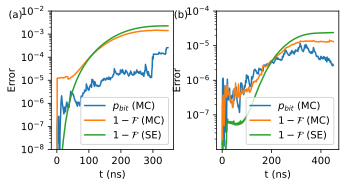

In [32]:
fig = plt.figure(figsize=(5, 2.5)) 
left = 0.15
subplot_width = 0.34
mid = 0.12
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+subplot_width,bottom=0.2,top = 0.97)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=left+subplot_width+mid, right=left+subplot_width+subplot_width+mid,bottom=0.2,top = 0.97)
axes = [fig.add_subplot(gs0[0]),  fig.add_subplot(gs1[0])]

from matplotlib.ticker import LogLocator


# ef
tot_time =400
tlist = np.linspace(0, tot_time, tot_time)
last_t_idx = 346
with open('ef_leakage.pkl', 'rb') as f:
    leakage_arr = pickle.load(f)
axes[0].plot(tlist[:last_t_idx+1], ((np.array(leakage_arr[0])+np.array(leakage_arr[2]))/2)[:last_t_idx+1],label=rf'$p_{{bit}}$ (MC)' )
with open('ef_mcsolve_infidelity_new.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[0].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (MC)' )
with open('../ef_larger_drive/sesolve_large_dim_a015_tomo_infidelity.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[0].set_ylabel('Error')
axes[0].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (SE)' )
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('t (ns)')
axes[0].set_ylim(1e-8,1e-2)
axes[0].set_yticks([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2])
axes[0].tick_params(axis='x', which='minor', bottom=False)
axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
# gf
tot_time =500
tlist = np.linspace(0, tot_time, tot_time)
last_t_idx = 449
with open('gf_bit.pkl', 'rb') as f:
    bitflip_arr = pickle.load(f)
axes[1].plot(tlist[:last_t_idx+1], ((np.array(bitflip_arr[0])+np.array(bitflip_arr[1]))/2)[:last_t_idx+1],label=rf'$p_{{bit}}$ (MC)' )
with open('gf_mcsolve_infidelity_three_lvl.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[1].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (MC)' )
with open('../gf_new/sesolve_large_dim_a015_tomo_infidelity.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[1].set_ylabel('Error')
axes[1].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (SE)' )
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-8,1e-4)
axes[1].set_yticks([1e-7,1e-6,1e-5,1e-4])
axes[1].set_xlabel('t (ns)')

axes[0].text(-0.35, 0.95, '(a)', transform=axes[0].transAxes)
axes[1].text(-0.35, 0.95, '(b)', transform=axes[1].transAxes)


# fig.savefig('fidelity.pdf')

# Combining the plots

In [60]:
freq_0pn = system_ef.evals[system_ef.product_to_dressed[(2,0)]] - system_ef.evals[system_ef.product_to_dressed[(1,0)]]
freq_50pn = system_ef.evals[system_ef.product_to_dressed[(2,50)]] - system_ef.evals[system_ef.product_to_dressed[(1,50)]]

Lambda_ef = (freq_50pn - freq_0pn)/50
print(f"Lambda_ef: {Lambda_ef}")


freq_0pn = system_gf.evals[system_gf.product_to_dressed[(2,0)]] - system_gf.evals[system_gf.product_to_dressed[(0,0)]]
freq_50pn = system_gf.evals[system_gf.product_to_dressed[(2,50)]] - system_gf.evals[system_gf.product_to_dressed[(0,50)]]

Lambda_gf = (freq_50pn - freq_0pn)/50
print(f"Lambda_gf: {Lambda_gf}")

Lambda_ef: 3.193710896660207e-05
Lambda_gf: -4.202532656050195e-06


 /home/kai/miniconda3/envs/dynamiqs/lib/python3.10/site-packages/matplotlib/cbook.py: 1709ComplexWarning: Casting complex values to real discards the imaginary part
 /home/kai/miniconda3/envs/dynamiqs/lib/python3.10/site-packages/matplotlib/cbook.py: 1345

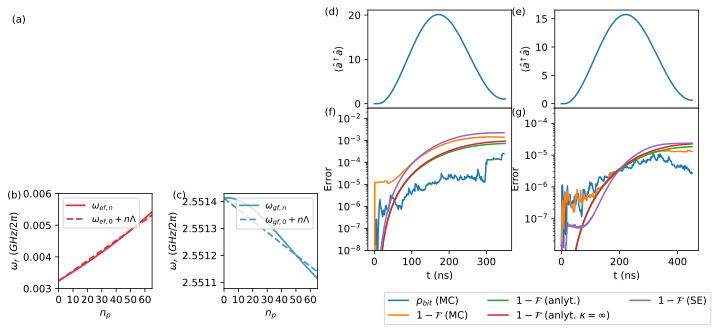

In [90]:
fig = plt.figure(figsize=(10, 4.4)) 


w = 0.13
hspace = 0.07
gs_ef_lamda = fig.add_gridspec(nrows=1, ncols=1,left=hspace, right=hspace+w,bottom=0.1,top = 0.4)
gs_gf_lamda = fig.add_gridspec(nrows=1, ncols=1,left=hspace*2+w+0.03, right=hspace*2+w*2+0.03,bottom=0.1,top = 0.4)
ax_ef_lamda = fig.add_subplot(gs_ef_lamda[0])
ax_gf_lamda = fig.add_subplot(gs_gf_lamda[0])
plot_ef_qbt_non_linearity(ax_ef_lamda,Lambda_ef)
plot_gf_qbt_non_linearity(ax_gf_lamda,Lambda_gf)




left = 0.44
w = 0.2
hspace = 0.06
gs_nbar_ef = fig.add_gridspec(nrows=1, ncols=1,left=left+hspace, right=left+hspace+w,
                                        bottom=0.67,top =0.98)
gs_nbar_gf = fig.add_gridspec(nrows=1, ncols=1,left=left+hspace*2+w, right=left+hspace*2+w*2,
                                        bottom=0.67,top =0.98)
ax_nbar_ef = fig.add_subplot(gs_nbar_ef[0])
ax_nbar_gf = fig.add_subplot(gs_nbar_gf[0])
last_t_idx = 349
ax_nbar_ef.plot(results_ef[3].expect[1][:last_t_idx+1].real)
ax_nbar_ef.set_xlabel('t (ns)')
ax_nbar_ef.set_ylabel(rf'$\langle \hat{{a}}^\dagger\hat{{a}} \rangle$')
ax_nbar_ef.set_xticks([])
ax_nbar_ef.set_xlabel('')
last_t_idx = 449
ax_nbar_gf.plot(results_gf[3].expect[1][:last_t_idx+1].real)
ax_nbar_gf.set_xlabel('t (ns)')
ax_nbar_gf.set_ylabel(rf'$\langle \hat{{a}}^\dagger\hat{{a}} \rangle$')
ax_nbar_gf.set_xticks([])
ax_nbar_gf.set_xlabel('')




gs0 = fig.add_gridspec(nrows=1, ncols=1,left=left+hspace, right=left+hspace+w,
                       bottom=0.22,top = 0.67)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=left+hspace*2+w, right=left+hspace*2+w*2,
                       bottom=0.22,top = 0.67)
axes = [fig.add_subplot(gs0[0]),  fig.add_subplot(gs1[0])]

from matplotlib.ticker import LogLocator

# ef
tot_time =400
tlist = np.linspace(0, tot_time, tot_time)
last_t_idx = 346
with open('ef_leakage.pkl', 'rb') as f:
    leakage_arr = pickle.load(f)
axes[0].plot(tlist[:last_t_idx+1], ((np.array(leakage_arr[0])+np.array(leakage_arr[2]))/2)[:last_t_idx+1],label=rf'$p_{{bit}}$ (MC)' )
with open('ef_mcsolve_infidelity_new.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[0].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (MC)' )

# Dephasing for e-f
tot_time = 400
tlist_ef_ori = np.linspace(0, tot_time, tot_time)
last_t_idx_ef = 349
ef_tlist =tlist_ef_ori[:last_t_idx_ef+1]
_, _, ef_dephasing = compute_dephasing_time_evolution(ef_tlist, results_ef[3].expect[1][:last_t_idx_ef+1], 
                                                      3.1 *1e-5,
                                                         1/3e-3,
                                                          uniform_num_points=2000)
axes[0].plot(ef_tlist,ef_dephasing,label=rf'$1-\mathcal{{F}}$ (anlyt.)' )


_, _, ef_dephasing = compute_dephasing_time_evolution(ef_tlist, results_ef[3].expect[1][:last_t_idx_ef+1], 
                                                      3.1 *1e-5,
                                                         1e4,
                                                          uniform_num_points=2000)
axes[0].plot(ef_tlist,ef_dephasing,label=rf'$1-\mathcal{{F}}$ (anlyt. $\kappa=\infty$)' )


with open('../ef_larger_drive/sesolve_large_dim_a015_tomo_infidelity.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[0].set_ylabel('Error')
axes[0].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (SE)' )
# axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('t (ns)')
axes[0].set_ylim(1e-8,3e-2)
axes[0].set_yticks([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2])
axes[0].tick_params(axis='x', which='minor', bottom=False)
axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))

# gf
tot_time =500
tlist = np.linspace(0, tot_time, tot_time)
last_t_idx = 449
with open('gf_bit.pkl', 'rb') as f:
    bitflip_arr = pickle.load(f)
axes[1].plot(tlist[:last_t_idx+1], ((np.array(bitflip_arr[0])+np.array(bitflip_arr[1]))/2)[:last_t_idx+1],label=rf'$p_{{bit}}$ (MC)' )
with open('gf_mcsolve_infidelity_three_lvl.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[1].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (MC)' )

tot_time =500
tlist_gf_ori = np.linspace(0, tot_time, tot_time)
last_t_idx_gf = 449
gf_tlist = tlist_gf_ori[:last_t_idx_gf+1]
_, _, gf_dephasing = compute_dephasing_time_evolution(gf_tlist, results_gf[3].expect[1][:last_t_idx_gf+1], 
                                                      4.2 *1e-6, 
                                                      1/2e-3, 
                                                      uniform_num_points=2000)
axes[1].plot(gf_tlist, gf_dephasing,label=rf'$1-\mathcal{{F}}$ (anlyt.)' )

_, _, gf_dephasing = compute_dephasing_time_evolution(gf_tlist, results_gf[3].expect[1][:last_t_idx_gf+1], 
                                                      4.2 *1e-6, 
                                                      1e4, 
                                                      uniform_num_points=2000)
axes[1].plot(gf_tlist, gf_dephasing,label=rf'$1-\mathcal{{F}}$ (anlyt. $\kappa=\infty$)' )

with open('../gf_new/sesolve_large_dim_a015_tomo_infidelity.pkl', 'rb') as f:
    infidelity = pickle.load(f)
axes[1].set_ylabel('Error')
axes[1].plot(tlist[:last_t_idx+1], infidelity[:last_t_idx+1],label=rf'$1-\mathcal{{F}}$ (SE)' )
# axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-8,3e-4)
axes[1].set_yticks([1e-7,1e-6,1e-5,1e-4])
axes[1].set_xlabel('t (ns)')

handles, labels = [], []
h, l = axes[0].get_legend_handles_labels()
handles.extend(h)
labels.extend(l)
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.75, -0.03))

ax_ef_lamda.text(-0.5, 2.8, '(a)', transform=ax_ef_lamda.transAxes)

ax_ef_lamda.text(-0.55, 0.95, '(b)', transform=ax_ef_lamda.transAxes)
ax_gf_lamda.text(-0.55, 0.95, '(c)', transform=ax_gf_lamda.transAxes)
ax_nbar_ef.text(-0.3, 0.95, '(d)', transform=ax_nbar_ef.transAxes)
ax_nbar_gf.text(-0.3, 0.95, '(e)', transform=ax_nbar_gf.transAxes)
axes[0].text(-0.3, 0.95, '(f)', transform=axes[0].transAxes)
axes[1].text(-0.3, 0.95, '(g)', transform=axes[1].transAxes)

fig.savefig('readout_error.pdf')

Lambda_ef: 3.193710896660207e-05
Lambda_gf: -4.202532656050195e-06
